# Knowledge transfer across species

In this notebook we perform the task of cross-species annotation using scTOP package. We use 80% of one species data to construct a basis to annotate the test set and other seven species. In order to be able to compare different species, we use orthology to map the genes from the seven species being annotated to the species used to create a basis.

First, we load the necessary packages and the spermatogenesis dataset for each species using the built-in function from transcriptformer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
try:
    import sctop as top
except:
    !pip install sctop
    import sctop as top
try:
    from transcriptformer.datasets import bgee_testis_evolution
except:
    !pip install transcriptformer
    from transcriptformer.datasets import bgee_testis_evolution
import scanpy as sc
import anndata as ad
from pybiomart import Server
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import mygene
import time

start_time = time.time()

species_names = ["human", "chimpanzee", "gorilla", "macaque", "marmoset", "mouse", "opossum", "platypus"]

print("Loading datasets...")
raw_adatas = {s: bgee_testis_evolution(organism=s) for s in species_names}
print("Datasets loaded successfully")

Loading datasets...
Datasets loaded successfully


Now, we define a function that map each species genes to the basis species.

In [2]:
ENSEMBL_CONFIG = {
    'human':      {'dataset': 'hsapiens_gene_ensembl',  'prefix': 'hsapiens'},
    'chimpanzee': {'dataset': 'ptroglodytes_gene_ensembl','prefix': 'ptroglodytes'},
    'gorilla':    {'dataset': 'ggorilla_gene_ensembl',   'prefix': 'ggorilla'},
    'macaque':    {'dataset': 'mmulatta_gene_ensembl',   'prefix': 'mmulatta'},
    'marmoset':   {'dataset': 'cjacchus_gene_ensembl',   'prefix': 'cjacchus'},
    'mouse':      {'dataset': 'mmusculus_gene_ensembl',  'prefix': 'mmusculus'},
    'opossum':    {'dataset': 'mdomestica_gene_ensembl', 'prefix': 'mdomestica'},
    'platypus':   {'dataset': 'oanatinus_gene_ensembl',  'prefix': 'oanatinus'}
}

server = Server('http://www.ensembl.org')
ensembl_mart = server.marts['ENSEMBL_MART_ENSEMBL']

def get_ortholog_mapping(source_basis, target_species):
    """Fetches 1:1 orthologs: Target IDs -> Basis IDs."""
    if source_basis == target_species:
        return None
    
    source_prefix = ENSEMBL_CONFIG[source_basis]['prefix']
    target_dataset_name = ENSEMBL_CONFIG[target_species]['dataset']
    homolog_attr = f"{source_prefix}_homolog_ensembl_gene"
    
    try:
        dataset = ensembl_mart.datasets[target_dataset_name]
        df = dataset.query(attributes=['ensembl_gene_id', homolog_attr], use_attr_names=True)
        df = df.dropna().drop_duplicates()
        
        df = df.drop_duplicates(subset=['ensembl_gene_id'], keep='first')
        df = df.drop_duplicates(subset=[homolog_attr], keep='first')
        
        return df.set_index('ensembl_gene_id')[homolog_attr]
    except Exception as e:
        print(f"  Warning: Could not fetch mapping for {target_species}->{source_basis}: {e}")
        return pd.Series(dtype=str)

Finally, we run the analysis for all species and analyze the F1-scores.

In [3]:
accuracy_matrix = pd.DataFrame(index=species_names, columns=species_names, dtype=float)
f1_matrix = pd.DataFrame(index=species_names, columns=species_names, dtype=float)
ortholog_counts_matrix = pd.DataFrame(index=species_names, columns=species_names, dtype=float)

for basis_species in species_names:
    print(f"\n===== REFERENCE BASIS: {basis_species.upper()} =====")
    
    basis_adata = raw_adatas[basis_species]
    results = top.create_basis(basis_adata, cell_type_column='cell_type', threshold = 50, plot_results=False, test_size = 0.1)
    current_basis = results['basis']
    print(f"  Basis created with {current_basis.shape[0]} native genes.")
    
    for target_species in species_names:
        target_raw = raw_adatas[target_species]
        
        if basis_species == target_species:
            accuracy_matrix.loc[basis_species, target_species] = results['metrics']['accuracy']
            f1_matrix.loc[basis_species, target_species] = results['metrics']['f1_macro']
            ortholog_counts_matrix.loc[basis_species, target_species] = len(results['basis'].index)
        else:
            mapping = get_ortholog_mapping(basis_species, target_species)
            
            valid_map = mapping[mapping.index.isin(target_raw.var_names)]
            n_orthologs = len(valid_map)
            
            if n_orthologs == 0:
                print(f"  Target: {target_species.ljust(12)} | SKIPPED (No matching genes in data)")
                ortholog_counts_matrix.loc[basis_species, target_species] = 0
                continue
                
            target_aligned = target_raw[:, valid_map.index].copy()
            target_aligned.var_names = valid_map.values
            
            target_aligned = target_aligned[:, ~target_aligned.var_names.duplicated()].copy()

            t_expr = pd.DataFrame(
                target_aligned.X.toarray(), 
                index=target_aligned.obs_names, 
                columns=target_aligned.var.index
            ).T
        
            processed_target = top.process(t_expr, average=False)
            scores = top.score(current_basis, processed_target)
            
            y_pred = scores.idxmax(axis=0)
            y_true = target_aligned.obs['cellTypeName']
            
            idx = y_true.index.intersection(y_pred.index)
            acc = accuracy_score(y_true[idx], y_pred[idx])
            f1_macro = f1_score(y_true[idx], y_pred[idx], average='macro')
    
            
            accuracy_matrix.loc[basis_species, target_species] = acc
            f1_matrix.loc[basis_species, target_species] = f1_macro
            ortholog_counts_matrix.loc[basis_species, target_species] = n_orthologs
            
            print(f"  Target: {target_species.ljust(12)} | Orthologs: {str(n_orthologs).ljust(6)} | F1-Macro: {f1_macro:.4f}")


===== REFERENCE BASIS: HUMAN =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Basis created: (34168, 7)
Total training cells: 14207
Total test cells: 1582

Scoring 1582 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9469
Top-3 Accuracy: 0.9981
Unspecified Rate: 0.0013
F1 Score (Macro): 0.9443
F1 Score (Weighted): 0.9486
Precision (Macro): 0.9340
Precision (Weighted): 0.9552
Recall (Macro): 0.9641
Recall (Weighted): 0.9469
  Basis created with 34168 native genes.
  Target: chimpanzee   | Orthologs: 14574  | F1-Macro: 0.9038
  Target: gorilla      | Orthologs: 16398  | F1-Macro: 0.8967
  Target: macaque      | Orthologs: 13551  | F1-Macro: 0.8591
  Target: marmoset     | Orthologs: 11497  | F1-Macro: 0.8602
  Target: mouse        | Orthologs: 15115  | F1-Macro: 0.6716
  Target: opossum      | Orthologs: 11809  | F1-Macro: 0.5976
  Target: platypus     | Orthologs: 13908  | F1-Macro: 0.3655

===== REFERENCE BASIS: CHIMPANZEE =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 7/7 [00:00<00:00, 12.75it/s]


Basis created: (15773, 7)
Total training cells: 11034
Total test cells: 1230

Scoring 1230 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9089
Top-3 Accuracy: 0.9967
Unspecified Rate: 0.0024
F1 Score (Macro): 0.9146
F1 Score (Weighted): 0.9099
Precision (Macro): 0.9159
Precision (Weighted): 0.9169
Recall (Macro): 0.9225
Recall (Weighted): 0.9089
  Basis created with 15773 native genes.
  Target: human        | Orthologs: 16933  | F1-Macro: 0.9504
  Target: gorilla      | Orthologs: 17502  | F1-Macro: 0.8829
  Target: macaque      | Orthologs: 13593  | F1-Macro: 0.8481
  Target: marmoset     | Orthologs: 11505  | F1-Macro: 0.8186
  Target: mouse        | Orthologs: 14932  | F1-Macro: 0.6854
  Target: opossum      | Orthologs: 11775  | F1-Macro: 0.6102
  Target: platypus     | Orthologs: 13801  | F1-Macro: 0.2826

===== REFERENCE BASIS: GORILLA =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 7/7 [00:00<00:00, 19.47it/s]


Basis created: (19457, 7)
Total training cells: 6564
Total test cells: 733

Scoring 733 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9018
Top-3 Accuracy: 0.9741
Unspecified Rate: 0.0191
F1 Score (Macro): 0.8886
F1 Score (Weighted): 0.9022
Precision (Macro): 0.8766
Precision (Weighted): 0.9062
Recall (Macro): 0.9065
Recall (Weighted): 0.9018
  Basis created with 19457 native genes.
  Target: human        | Orthologs: 16638  | F1-Macro: 0.8766
  Target: chimpanzee   | Orthologs: 14530  | F1-Macro: 0.7408
  Target: macaque      | Orthologs: 13421  | F1-Macro: 0.6757
  Target: marmoset     | Orthologs: 11421  | F1-Macro: 0.7259
  Target: mouse        | Orthologs: 14792  | F1-Macro: 0.6719
  Target: opossum      | Orthologs: 11683  | F1-Macro: 0.4246
  Target: platypus     | Orthologs: 13696  | F1-Macro: 0.3908

===== REFERENCE BASIS: MACAQUE =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 7/7 [00:00<00:00, 26.21it/s]


Basis created: (14722, 7)
Total training cells: 6832
Total test cells: 763

Scoring 763 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  9.14it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9069
Top-3 Accuracy: 0.9948
Unspecified Rate: 0.0066
F1 Score (Macro): 0.8926
F1 Score (Weighted): 0.9082
Precision (Macro): 0.8811
Precision (Weighted): 0.9162
Recall (Macro): 0.9132
Recall (Weighted): 0.9069
  Basis created with 14722 native genes.
  Target: human        | Orthologs: 16129  | F1-Macro: 0.9480
  Target: chimpanzee   | Orthologs: 13758  | F1-Macro: 0.9032
  Target: gorilla      | Orthologs: 15646  | F1-Macro: 0.8936
  Target: marmoset     | Orthologs: 11206  | F1-Macro: 0.8907
  Target: mouse        | Orthologs: 14494  | F1-Macro: 0.6883
  Target: opossum      | Orthologs: 11459  | F1-Macro: 0.5709
  Target: platypus     | Orthologs: 13418  | F1-Macro: 0.4365

===== REFERENCE BASIS: MARMOSET =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 7/7 [00:00<00:00, 32.05it/s]


Basis created: (12237, 7)
Total training cells: 5729
Total test cells: 641

Scoring 641 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]



FINAL RESULTS

Accuracy (Top-1): 0.8955
Top-3 Accuracy: 0.9875
Unspecified Rate: 0.0000
F1 Score (Macro): 0.8976
F1 Score (Weighted): 0.8970
Precision (Macro): 0.8932
Precision (Weighted): 0.9050
Recall (Macro): 0.9067
Recall (Weighted): 0.8955
  Basis created with 12237 native genes.
  Target: human        | Orthologs: 15879  | F1-Macro: 0.9047
  Target: chimpanzee   | Orthologs: 13453  | F1-Macro: 0.7994
  Target: gorilla      | Orthologs: 15442  | F1-Macro: 0.8792
  Target: macaque      | Orthologs: 13021  | F1-Macro: 0.7746
  Target: mouse        | Orthologs: 14518  | F1-Macro: 0.6895
  Target: opossum      | Orthologs: 11457  | F1-Macro: 0.4920
  Target: platypus     | Orthologs: 13464  | F1-Macro: 0.3947

===== REFERENCE BASIS: MOUSE =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 6/6 [00:00<00:00, 17.90it/s]


Basis created: (24027, 6)
Total training cells: 4727
Total test cells: 529

Scoring 529 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9357
Top-3 Accuracy: 0.9981
Unspecified Rate: 0.0019
F1 Score (Macro): 0.9304
F1 Score (Weighted): 0.9357
Precision (Macro): 0.9237
Precision (Weighted): 0.9412
Recall (Macro): 0.9411
Recall (Weighted): 0.9357
  Basis created with 24027 native genes.
  Target: human        | Orthologs: 15834  | F1-Macro: 0.6344
  Target: chimpanzee   | Orthologs: 13242  | F1-Macro: 0.5759
  Target: gorilla      | Orthologs: 15177  | F1-Macro: 0.4869
  Target: macaque      | Orthologs: 12948  | F1-Macro: 0.6087
  Target: marmoset     | Orthologs: 11158  | F1-Macro: 0.5894
  Target: opossum      | Orthologs: 11805  | F1-Macro: 0.7768
  Target: platypus     | Orthologs: 13880  | F1-Macro: 0.4412

===== REFERENCE BASIS: OPOSSUM =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 6/6 [00:00<00:00, 13.32it/s]


Basis created: (15793, 6)
Total training cells: 8891
Total test cells: 991

Scoring 991 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  7.84it/s]



FINAL RESULTS

Accuracy (Top-1): 0.9294
Top-3 Accuracy: 0.9990
Unspecified Rate: 0.0050
F1 Score (Macro): 0.9035
F1 Score (Weighted): 0.9306
Precision (Macro): 0.8932
Precision (Weighted): 0.9358
Recall (Macro): 0.9208
Recall (Weighted): 0.9294
  Basis created with 15793 native genes.
  Target: human        | Orthologs: 14131  | F1-Macro: 0.5595
  Target: chimpanzee   | Orthologs: 11943  | F1-Macro: 0.5769
  Target: gorilla      | Orthologs: 13674  | F1-Macro: 0.4702
  Target: macaque      | Orthologs: 11769  | F1-Macro: 0.5526
  Target: marmoset     | Orthologs: 10236  | F1-Macro: 0.4739
  Target: mouse        | Orthologs: 13572  | F1-Macro: 0.7605
  Target: platypus     | Orthologs: 13356  | F1-Macro: 0.3984

===== REFERENCE BASIS: PLATYPUS =====

Creating basis with single train-test split

Building cell type basis (parallelized)...


Creating basis (parallel): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Basis created: (18096, 5)
Total training cells: 6071
Total test cells: 678

Scoring 678 test cells (parallel, 4 workers)...


Scoring chunks (parallel): 100%|██████████| 10/10 [00:01<00:00,  8.05it/s]



FINAL RESULTS

Accuracy (Top-1): 0.8510
Top-3 Accuracy: 0.9956
Unspecified Rate: 0.0015
F1 Score (Macro): 0.8813
F1 Score (Weighted): 0.8511
Precision (Macro): 0.8633
Precision (Weighted): 0.8819
Recall (Macro): 0.9210
Recall (Weighted): 0.8510
  Basis created with 18096 native genes.
  Target: human        | Orthologs: 13728  | F1-Macro: 0.4839
  Target: chimpanzee   | Orthologs: 11592  | F1-Macro: 0.4365
  Target: gorilla      | Orthologs: 13272  | F1-Macro: 0.4126
  Target: macaque      | Orthologs: 11471  | F1-Macro: 0.4272
  Target: marmoset     | Orthologs: 9986   | F1-Macro: 0.4198
  Target: mouse        | Orthologs: 13208  | F1-Macro: 0.6399
  Target: opossum      | Orthologs: 11115  | F1-Macro: 0.6098


Plots for visualization of results

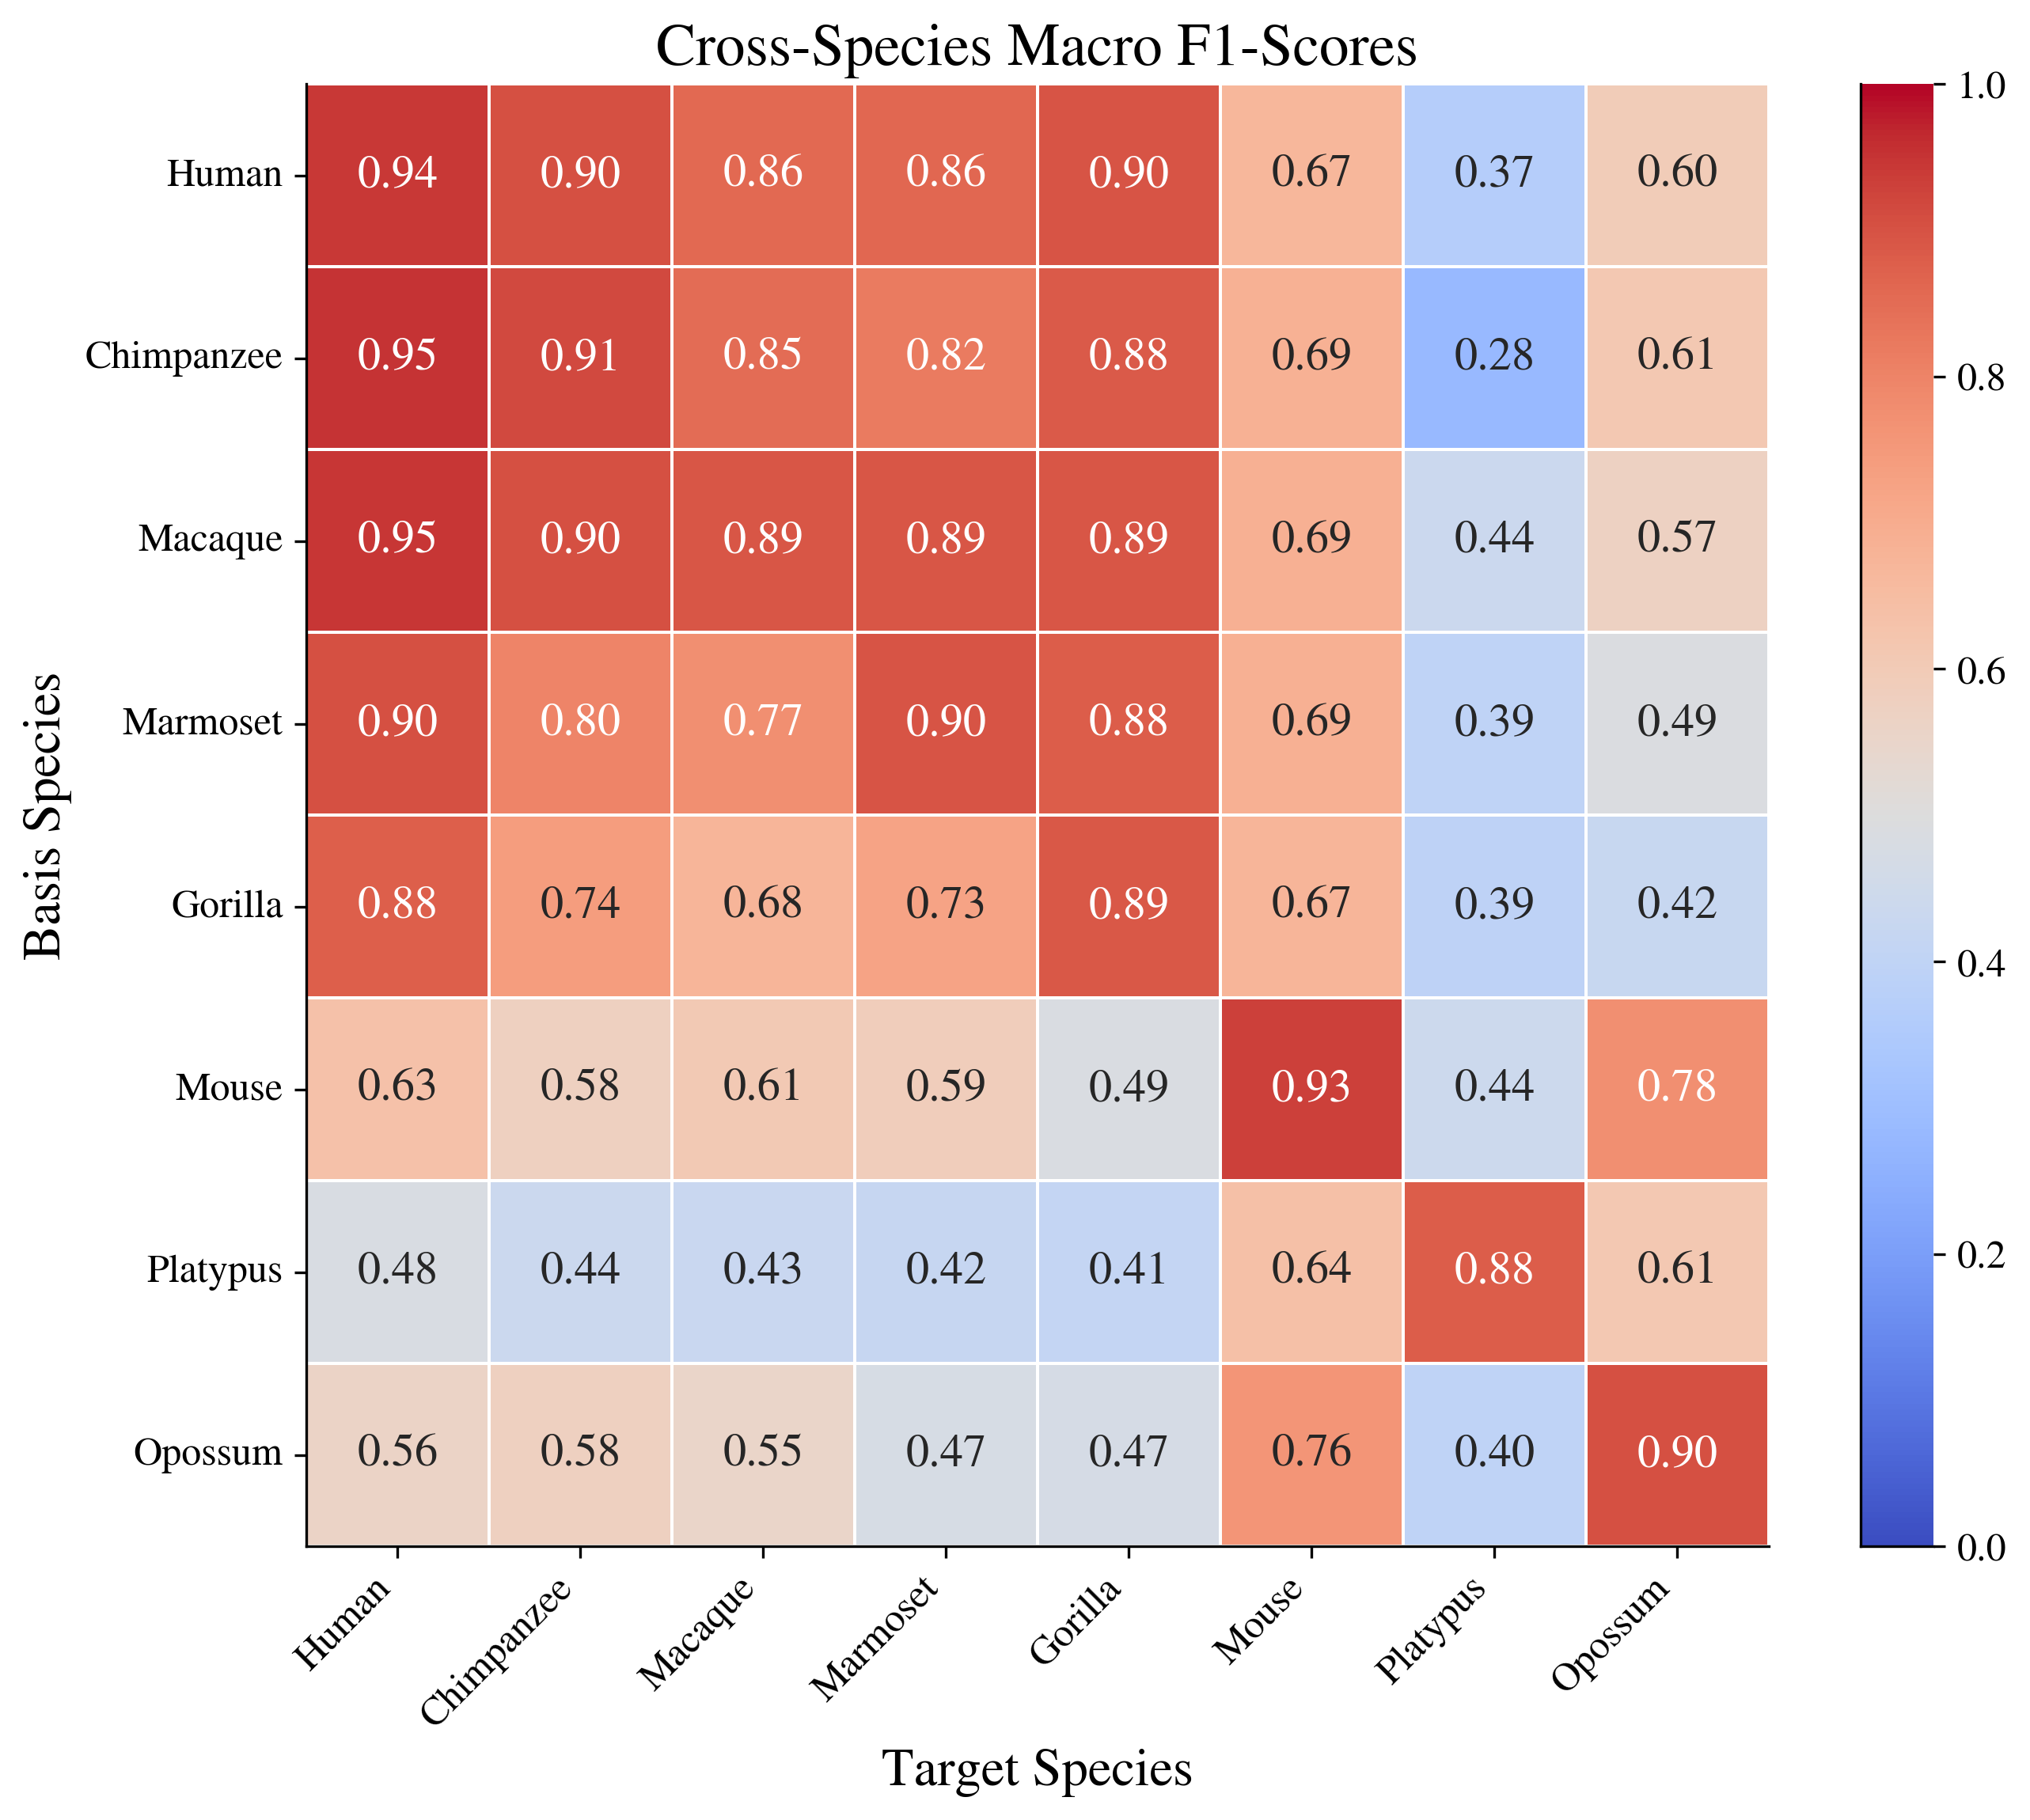

In [10]:
species_labels = [
    'Human', 'Chimpanzee', 'Macaque', 'Marmoset', 'Gorilla',
    'Mouse', 'Platypus', 'Opossum'
]


f1_matrix.index = f1_matrix.index.str.capitalize()
f1_matrix.columns = f1_matrix.columns.str.capitalize()


f1_matrix = f1_matrix.reindex(index=species_labels, columns=species_labels)

data_sctop = f1_matrix.values

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

plt.rcParams.update({
    "font.size": 14, 
    "axes.labelsize": 16, 
    "axes.titlesize": 18, 
    "xtick.labelsize": 12, 
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 20,
    "figure.dpi": 300,
    "axes.linewidth": 0.8
})

plt.figure(figsize=(10,8))
ax = sns.heatmap(f1_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=0.0, vmax=1.0,square=True, linewidths=0.5)
ax.set_xticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.title("Cross-Species Macro F1-Scores")
plt.ylabel("Basis Species")
plt.xlabel("Target Species")
sns.despine(left=False, bottom=False)

plt.savefig('cross_species_heatmap.svg', bbox_inches="tight", transparent=True)

plt.show()

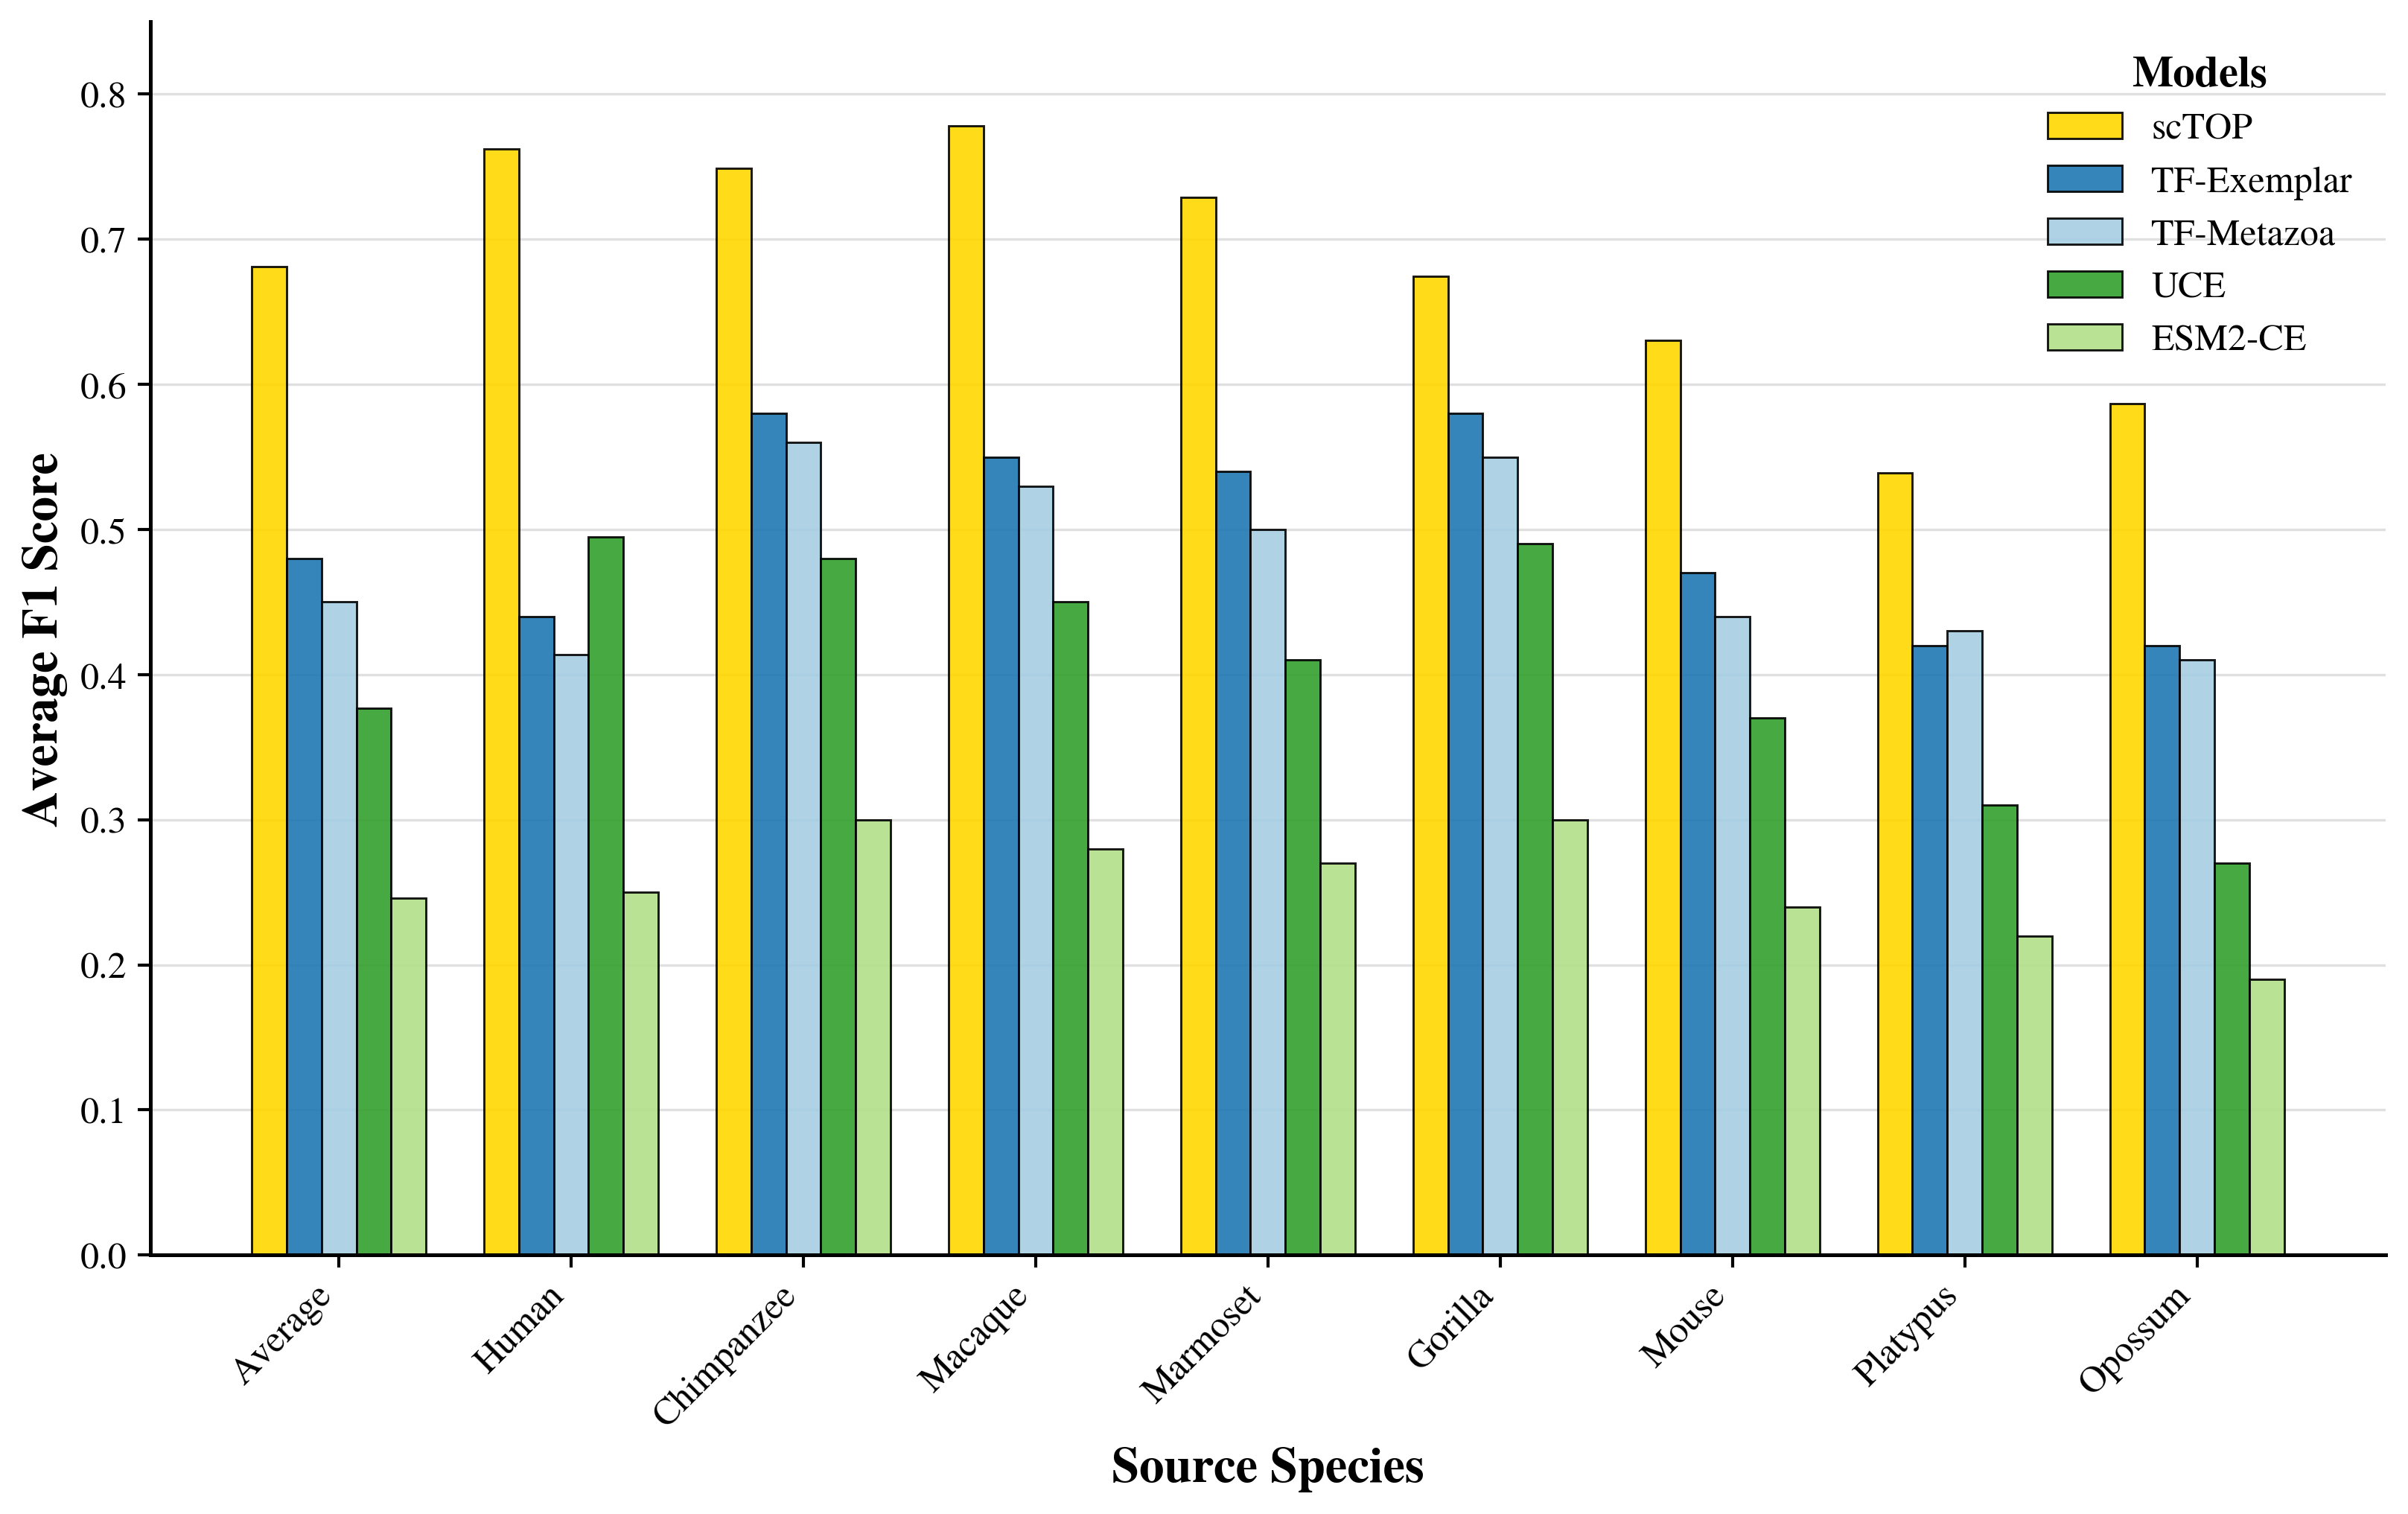

In [11]:
species = [
    "Average", "Human", "Chimpanzee", "Macaque", "Marmoset",
    "Gorilla", "Mouse", "Platypus", "Opossum"
]

f1_scores = {
    "scTOP":       [data_sctop[:].mean(), data_sctop[0].mean(), data_sctop[1].mean(), data_sctop[2].mean(), data_sctop[3].mean(), data_sctop[4].mean(), data_sctop[5].mean(), data_sctop[6].mean(), data_sctop[7].mean()],
    "TF-Exemplar": [0.480, 0.440, 0.580, 0.550, 0.540, 0.580, 0.470, 0.420, 0.420],
    "TF-Metazoa":  [0.450, 0.414, 0.560, 0.530, 0.500, 0.550, 0.440, 0.430, 0.410],
    "UCE":         [0.377, 0.495, 0.480, 0.450, 0.410, 0.490, 0.370, 0.310, 0.270],
    "ESM2-CE":     [0.246, 0.250, 0.300, 0.280, 0.270, 0.300, 0.240, 0.220, 0.190]
}


new_colors = {
    "scTOP":       "#FFD700", 
    "TF-Exemplar": "#1f78b4", 
    "TF-Metazoa":  "#a6cee3", 
    "UCE":         "#33a02c", 
    "ESM2-CE":     "#b2df8a"
}


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

plt.rcParams.update({
    "font.size": 14, 
    "axes.labelsize": 16, 
    "axes.titlesize": 18, 
    "xtick.labelsize": 12, 
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 20,
    "figure.dpi": 300,
    "axes.linewidth": 0.8
})

fig, ax = plt.subplots(figsize=(11, 7))

x = np.arange(len(species))
width = 0.15 # Width of each bar
n_models = len(f1_scores)

sorted_models = ["scTOP", "TF-Exemplar", "TF-Metazoa", "UCE", "ESM2-CE"] 

for i, model in enumerate(sorted_models):
    scores = f1_scores[model]
    offset = (i - (n_models - 1) / 2) * width
    ax.bar(
        x + offset,
        scores,
        width,
        label=model,
        color=new_colors[model],
        edgecolor='black',
        linewidth=0.7,
        alpha=0.9
    )
    
ax.set_ylabel("Average F1 Score", fontsize=16, weight='bold')
ax.set_xlabel("Source Species", fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha="right", fontsize=12)
ax.tick_params(axis='y', length=4, width=1) 
ax.tick_params(axis='x', length=4, width=1)

ax.set_ylim(0, 0.85) 
ax.set_yticks(np.arange(0, 0.9, 0.1)) 

ax.legend(
    title='Models', 
    title_fontproperties={'weight': 'bold'}, # <-- This is the fix
    frameon=False, 
    loc='upper right', 
    bbox_to_anchor=(1.0, 1.0)
)


ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.7)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()

plt.savefig('cross_species_comparison.svg', bbox_inches="tight", transparent=True)
plt.show()

In [6]:
end_time = time.time()
print(f"Total time running: {end_time - start_time}")

Total time running: 719.7199468612671
